This notebook how to run inference with the model trained in [this notebook](https://colab.research.google.com/github/sayakpaul/TF-2.0-Hacks/blob/master/Training_a_pets_detector_model_within_minutes_with_TFOD_API.ipynb). 

## Set up TFOD API

In [2]:
import tensorflow as tf 
print(tf.__version__)

2.3.1


In [ ]:
#!git clone https://github.com/tensorflow/models.git

In [4]:
%cd models/

/home/lenovo/CSE/sem7/CIP/objectdetection/models


In [5]:
%cd research

# Compile protos.
!protoc object_detection/protos/*.proto --python_out=.

# Install TensorFlow Object Detection API.
#!cp object_detection/packages/tf2/setup.py .
#!python -m pip install .

/home/lenovo/CSE/sem7/CIP/objectdetection/models/research


In [34]:
!python research/object_detection/builders/model_builder_test.py
#might give a contrib error, don't mind it

2020-10-21 08:18:22.536503: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2020-10-21 08:18:22.536538: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Traceback (most recent call last):
  File "research/object_detection/builders/model_builder_test.py", line 21, in <module>
    from object_detection.builders import model_builder
  File "/home/lenovo/anaconda3/lib/python3.7/site-packages/object_detection/builders/model_builder.py", line 22, in <module>
    from object_detection.builders import box_predictor_builder
  File "/home/lenovo/anaconda3/lib/python3.7/site-packages/object_detection/builders/box_predictor_builder.py", line 20, in <module>
    from object_detection.predictors import convolutional_box_predictor
  File "/home/lenovo/anaconda3/lib/pyth

## Set up GCP utilities

In [ ]:
#from google.colab import auth as google_auth
#google_auth.authenticate_user()

In [ ]:
#@title Configure GCP project
#GCP_PROJECT_ID = "fast-ai-exploration" #@param {type:"string"} 
#!gcloud config set project $GCP_PROJECT_ID

In [ ]:
#@title GCS bucket name
#YOUR_GCS_BUCKET = "pet_detector_tf2" #@param {type:"string"}
#YOUR_GCS_BUCKET = 'gs://' + YOUR_GCS_BUCKET
#print(f'GCS bucket to be used: {YOUR_GCS_BUCKET}')

## Copy the model checkpoints locally

In [35]:
#@title Model directory name
MODEL_DIR = "train" #@param {type:"string"}



## Model config file

From here, we are going to follow [this notebook](https://github.com/tensorflow/models/blob/master/research/object_detection/colab_tutorials/inference_tf2_colab.ipynb). 

## Utilities for running inference

In [36]:
import matplotlib
import matplotlib.pyplot as plt

import io
import os
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

## Load the model checkpoints as a standalone function

In [37]:
pipeline_config = '/home/lenovo/CSE/sem7/CIP/objectdetection/models/pipeline.config'
model_dir = '/home/lenovo/CSE/sem7/CIP/objectdetection/models/train'

In [41]:
#make sure pwd is in models/
!pwd

/home/lenovo/CSE/sem7/CIP/objectdetection/models


In [42]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
detection_model = model_builder.build(
      model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(
      model=detection_model)
ckpt.restore(os.path.join(model_dir, 'model.ckpt-1236')).expect_partial() # Can vary 

def get_model_detection_function(model):
  """Get a tf.function for detection."""

  @tf.function
  def detect_fn(image):
    """Detect objects in image."""

    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

  return detect_fn

detect_fn = get_model_detection_function(detection_model)

## Prepare label map for converting class ids to labels

In [43]:
label_map_path = configs['eval_input_config'].label_map_path
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

In [44]:
!pwd

/home/lenovo/CSE/sem7/CIP/objectdetection/models


In [45]:
label_map_path = configs['eval_input_config'].label_map_path
print(label_map_path)

annotations/label_map.pbtxt


## Image processing utils

In [18]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

## Prepare an image and run inference

In [ ]:
#@title Supply a path to download a relevant image
#IMAGE_PATH = ://www.gannett-cdn.com/-mm-/8b15e053fba5438a91d1bff3d4704868a0ce7579/c=68-0-731-373/local/-/media/2018/05/10/USATODAY/usatsports/MotleyFool-TMOT-816b1ceb-0ece06e3.jpg?width=660&height=372&fit=crop&form

In [46]:
image_np = load_image_into_numpy_array('/home/lenovo/CSE/sem7/CIP/objectdetection/models/research/object_detection/test_images/15.jpg')
image_np.shape

(600, 800, 3)

In [47]:
input_tensor = tf.convert_to_tensor(
    np.expand_dims(image_np, 0), dtype=tf.float32)
detections, predictions_dict, shapes = detect_fn(input_tensor)

label_id_offset = 1
image_np_with_detections = image_np.copy()

INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0


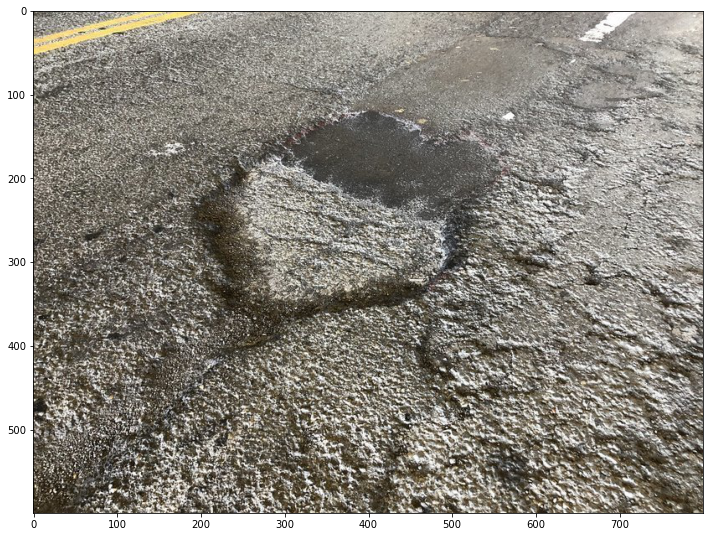

In [48]:
viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'][0].numpy(),
      (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
      detections['detection_scores'][0].numpy(),
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.30,
      agnostic_mode=False,
      keypoints=None,
      keypoint_scores=None,
      keypoint_edges=None)

plt.figure(figsize=(12,16))
plt.imshow(image_np_with_detections)
plt.show()